In [0]:
!pip uninstall tensorflow tensorflow-gpu --yes
!pip install -U --pre tensorflow-gpu==2.0.0b1

使用tensorflow-gpu 2.0.0b1

In [0]:
import tensorflow as tf
import numpy as np
import cv2
import dlib
import glob
import matplotlib.pyplot as plt

print(tf.__version__)

用來印出處理後的圖片 -> print_img

In [0]:
def print_img(dataset, num = None):
  ts = dataset
  for i in ts:
    plt.figure()
    plt.imshow(i.numpy()[:,:,0], cmap = 'gray')


*   detect_face 偵測人臉．
*   crop_face 把人臉裁切出來．
*   img_histeq　對人臉使用直方圖均衡化．
*   face_resize　把人臉圖片縮放成48×48大小．
*   predict 把經過face_resize處理過的圖片送進模型預測．
*   show_image 把預測結果印回原本輸入的圖片．

In [0]:
class face_img():
  def __init__(self, img_path, next_step, show_output_img = False):
    self.model_path = 'my_seq_clr.h5'
    self.next_step = next_step
    self.show_output_img = show_output_img
    if img_path.split('.')[-1] == 'jpg':
      self.img_path = img_path
      self.img_raw = tf.io.decode_jpeg(tf.io.read_file(self.img_path), channels = 1)
    elif img_path.split('.')[-1] == 'png':
      self.img_path = img_path
      self.img_raw = tf.io.decode_jpeg(tf.io.read_file(self.img_path), channels = 1)
    else:
      print('image format only allow JPG, PNG.')
      return 1

  def show_image(self):
    colors = {'Angry': (255, 0, 0), 'Disgust': (255, 255, 0), 'Fear': (0, 0, 255 ), 'Happiness': (0, 127, 255), 
               'Sadness': (139, 0, 255), 'Surprise': (240, 255, 240), 'Neutral': (0, 255, 0)}
    img = cv2.imread(self.img_path)
    for i, rect in enumerate(self.face_rectangles):
      left_top_coord = (rect.left(), rect.top())
      right_bottom_coord = (rect.right(), rect.bottom())
      cv2.rectangle(img, left_top_coord, right_bottom_coord, colors[self.output_class[i]], 5)
      font_coord = (int(0.5 * (rect.right() + rect.left()))-20 , rect.top()-10)
      cv2.putText(img, self.output_class[i], font_coord, cv2.FONT_HERSHEY_SIMPLEX, 1, colors[self.output_class[i]], 2)
    plt.axis('off')
    if self.show_output_img:
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_title = self.img_path.split('/')[-1].split('.')[0]

    dir_saving = 'img_demo_output/'
    cv2.imwrite(dir_saving + img_title + '.png', img)

  def predict(self):
    clr = tf.keras.models.load_model(self.model_path)
    self.face_be_pred = self.face_be_pred.map(lambda img: img/float(255))
    self.face_be_pred = self.face_be_pred.batch(1)

    pred = clr.predict(self.face_be_pred, verbose=1)
    output_class = list(zip(pred, np.max(pred, axis = 1)))
    output_class = list(map(lambda x: np.where(x[0]==x[1])[0][0], output_class))
    emotions = ['Angry', 'Disgust', 'Fear', 'Happiness',
           'Sadness', 'Surprise', 'Neutral']
    self.output_class = list(map(lambda x: emotions[x], output_class))   
    print(self.output_class)

  def face_resize(self):
    norm_h, norm_w, channel = (48,48,1)
    for i, face in enumerate(self.face_be_pred):
      f_shape = face.shape.as_list()
      if max(f_shape) >= norm_h:
      # dowmsampling
        resized = tf.image.resize(face, [norm_h, norm_w], method = 'bilinear',  antialias = True)
        self.face_be_pred[i] = resized
      else:
      # upsampling
        resized = tf.image.resize(face, [norm_h, norm_w], method = tf.image.ResizeMethod.BICUBIC)
        self.face_be_pred[i] = resized
    self.face_be_pred = tf.data.Dataset.from_tensor_slices([*self.face_be_pred])
    nexT = self.next_step[2]
    if nexT:
      self.predict()
  
  def img_histeq(self):
    for i, face in enumerate(self.face_be_pred):
      eq = cv2.equalizeHist(face.numpy())[:,:, np.newaxis]
      self.face_be_pred[i] = tf.convert_to_tensor(eq)
    nexT = self.next_step[1]
    if nexT:
      self.face_resize()
  
  def crop_face(self): 
    self.face_be_pred = np.empty(shape =(len(self.face_rectangles)), dtype = object)
    for i, rect in enumerate(self.face_rectangles):
      top_left_corner = [rect.top(), rect.left()]
      target_h_w = [rect.bottom() - top_left_corner[0], rect.right() - top_left_corner[1]]

      try:
        self.face_be_pred[i] = tf.image.crop_to_bounding_box(self.img_raw, top_left_corner[0], top_left_corner[1], target_h_w[0], target_h_w[1])
      except ValueError as e:
        raw_h,raw_w = self.img_raw.numpy().shape[:-1]
        if str(e) == 'width must be >= target + offset.':       
          self.face_be_pred[i] = tf.image.crop_to_bounding_box(self.img_raw, top_left_corner[0], top_left_corner[1], target_h_w[0], raw_w-top_left_corner[1])
        elif str(e) == 'height must be >= target + offset.':
          self.face_be_pred[i] = tf.image.crop_to_bounding_box(self.img_raw, top_left_corner[0], top_left_corner[1], raw_h-top_left_corner[0], target_h_w[1])
        else:
          print(e)
          break
    nexT = self.next_step[0]
    if nexT:
      self.img_histeq()

  def detect_face(self):
    face_detector = dlib.get_frontal_face_detector()
    self.face_rectangles = face_detector(self.img_raw.numpy(), 3)
    print('The image has {} face.'.format(len(self.face_rectangles)) if len(self.face_rectangles) == 1 
          else 'The image has {} faces.'.format(len(self.face_rectangles)))
    self.crop_face()

範例圖片 -> triple2.jpg

In [0]:
img_title = './img_demo/triple2.jpg'

# Cropping Face

The image has 3 faces.


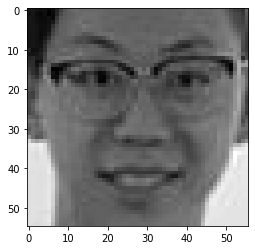

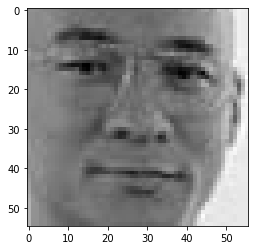

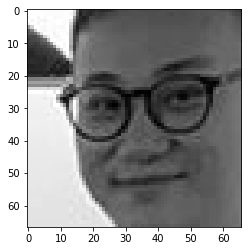

In [0]:
ts = face_img(img_title,[0,0,0])
ts.detect_face()
print_img(ts.face_be_pred)

# Histogram Equalization

The image has 3 faces.


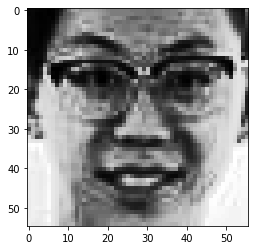

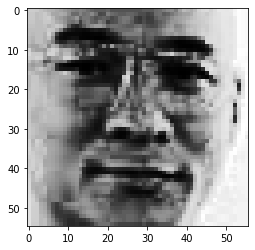

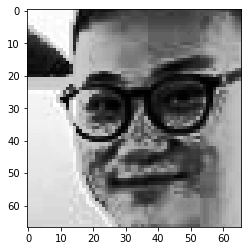

In [0]:
ts = face_img(img_title, [1,0,0])
ts.detect_face()
print_img(ts.face_be_pred)

# Resizing Image 

The image has 3 faces.


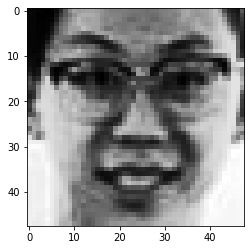

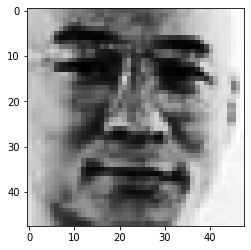

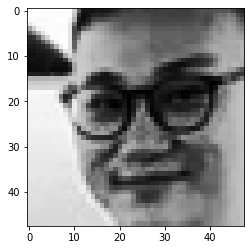

In [0]:
if __name__ == '__main__':   
  ts = face_img(img_title, [1,1,0])
  ts.detect_face()
  print_img(ts.face_be_pred)

# Show Output

The image has 3 faces.
3/3 [==============================] - 0s 90ms/step
['Happiness', 'Neutral', 'Happiness']


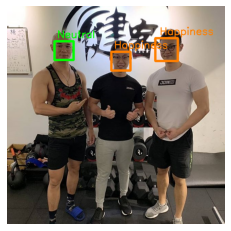

In [0]:
ts = face_img(img_title, [1,1,1], True)
ts.detect_face()
ts.show_image()

# Handle all demo images

./img_demo/triple2.jpg
The image has 3 faces.
3/3 [==============================] - 0s 90ms/step
['Happiness', 'Neutral', 'Happiness']
./img_demo/pair2.png
The image has 2 faces.
2/2 [==============================] - 0s 134ms/step
['Happiness', 'Neutral']
./img_demo/four2.jpg
The image has 4 faces.
4/4 [==============================] - 0s 67ms/step
['Happiness', 'Happiness', 'Happiness', 'Sadness']
./img_demo/triple1.jpg
The image has 3 faces.
3/3 [==============================] - 0s 88ms/step
['Angry', 'Happiness', 'Happiness']
./img_demo/single3.jpg
The image has 1 face.
1/1 [==============================] - 0s 262ms/step
['Sadness']
./img_demo/four.jpg
The image has 4 faces.
4/4 [==============================] - 0s 68ms/step
['Happiness', 'Happiness', 'Happiness', 'Neutral']
./img_demo/four1.jpg
The image has 4 faces.
4/4 [==============================] - 0s 69ms/step
['Happiness', 'Happiness', 'Happiness', 'Happiness']
./img_demo/triple3.jpg
The image has 3 faces.
3/3 [=====

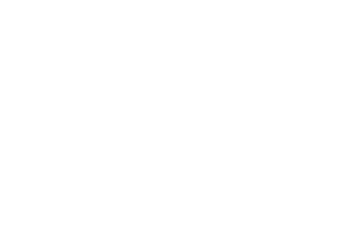

In [0]:
dir_img_path = './img_demo' 
for each in glob.iglob(dir_img_path + '/*.*'):
  print(each)
  img = face_img(each,[1,1,1])
  img.detect_face()
  img.show_image()
  del img